# BRAIN TUMOUR CLASSIFICATION

# Importing Necessary Liabraries

In [1]:
import os
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Load and preprocess data

In [2]:
train_dir = r"E:\Brain Tumor Classification\Training"
test_dir = r"E:\Brain Tumor Classification\Testing"
image_size = (128, 128)

In [3]:
def load_and_resize_images_from_folder(folder, image_size):
    images = []
    labels = []
    for class_name in os.listdir(folder):
        class_dir = os.path.join(folder, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = Image.open(img_path).resize(image_size)
            if img is not None:
                images.append(np.array(img))
                labels.append(class_name)
    return np.array(images), np.array(labels)

In [4]:
train_images, train_labels = load_and_resize_images_from_folder(train_dir, image_size)
test_images, test_labels = load_and_resize_images_from_folder(test_dir, image_size)

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

assert len(train_images) == len(train_labels), "Mismatch between images and labels in training data"
assert len(test_images) == len(test_labels), "Mismatch between images and labels in testing data"

# Data visualization

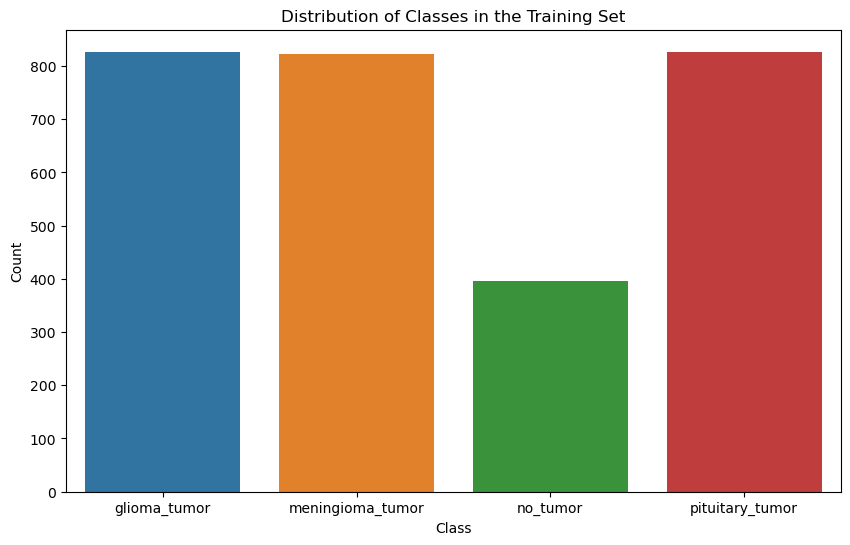

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x=train_labels)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in the Training Set')
plt.show()

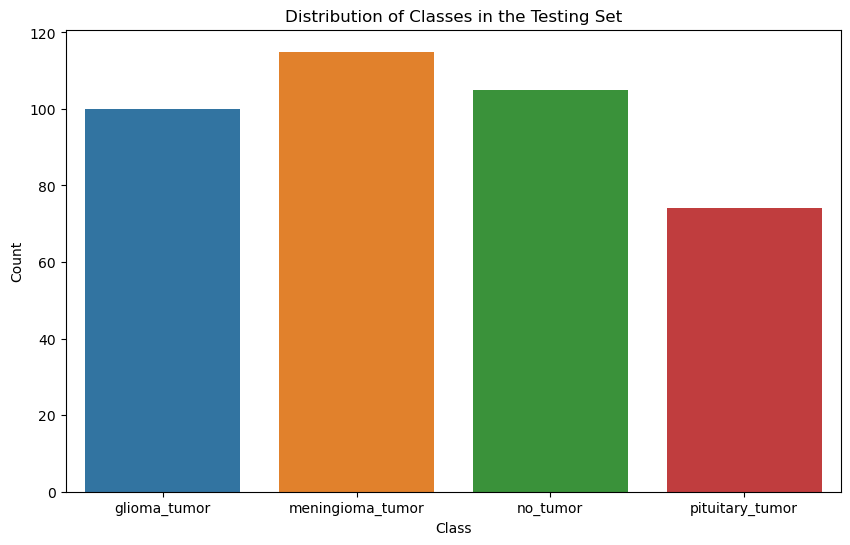

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x=test_labels)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in the Testing Set')
plt.show()

# Data augmentation

In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

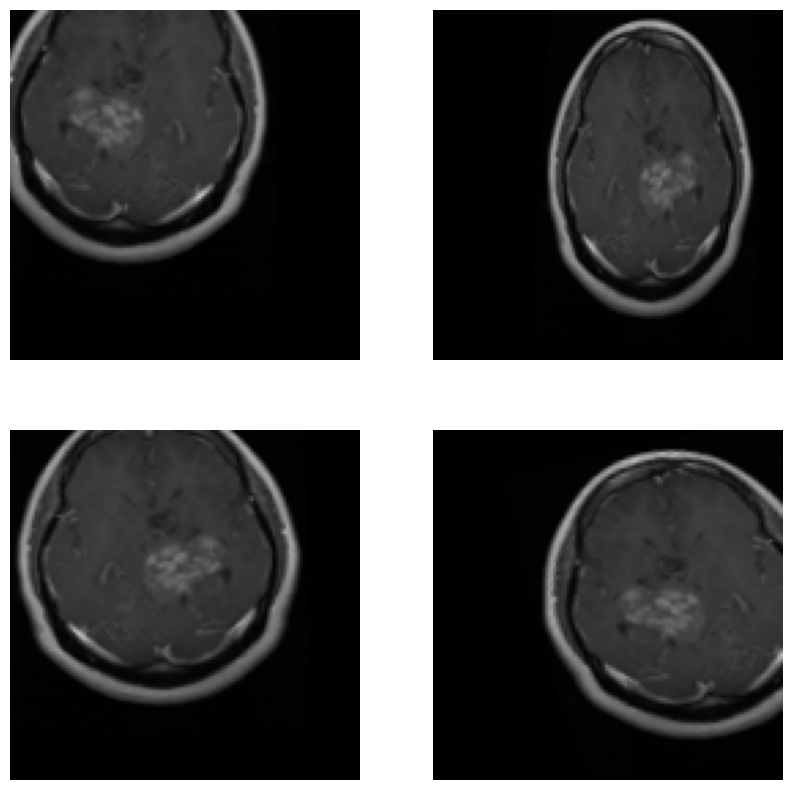

In [8]:
# Check the output of the data generator
sample_image = train_images[0] * 255
sample_image = sample_image.astype('uint8')
sample_image = sample_image.reshape((1,) + sample_image.shape)

i = 0
plt.figure(figsize=(10, 10))
for batch in datagen.flow(sample_image, batch_size=1):
    plt.subplot(2, 2, i + 1)
    img = batch[0].astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    i += 1
    if i % 4 == 0:
        break
plt.show()

# Build and compile the model using transfer learning with VGG16

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(np.unique(train_labels)), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# Split data for training and validation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model

In [11]:
results = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32),
    epochs=50,  # Increased number of epochs
    validation_data=(X_val, y_val_encoded),
    class_weight=class_weights 
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.4590 - loss: 1.6300 - val_accuracy: 0.5767 - val_loss: 1.2114
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.6098 - loss: 1.0779 - val_accuracy: 0.7648 - val_loss: 0.6241
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.6626 - loss: 0.9022 - val_accuracy: 0.7578 - val_loss: 0.6014
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.7223 - loss: 0.7685 - val_accuracy: 0.7753 - val_loss: 0.6764
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.7202 - loss: 0.6922 - val_accuracy: 0.7753 - val_loss: 0.6568
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7337 - loss: 0.7027 - val_accuracy: 0.8310 - val_loss: 0.4533
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.7535 - loss: 0.6195 - val_accuracy: 0.7056 - val_loss: 0.9394
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7564 - loss: 0.5948 - val_accuracy: 0.7822 - v

# Evaluate the model

In [12]:
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print(f"Validation Accuracy: {val_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8269 - loss: 0.4465
Validation Accuracy: 0.8362369537353516


In [13]:
test_labels_encoded = label_encoder.transform(test_labels)
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print(f"Test Accuracy: {test_accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4422 - loss: 2.7707
Test Accuracy: 0.624365508556366


13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


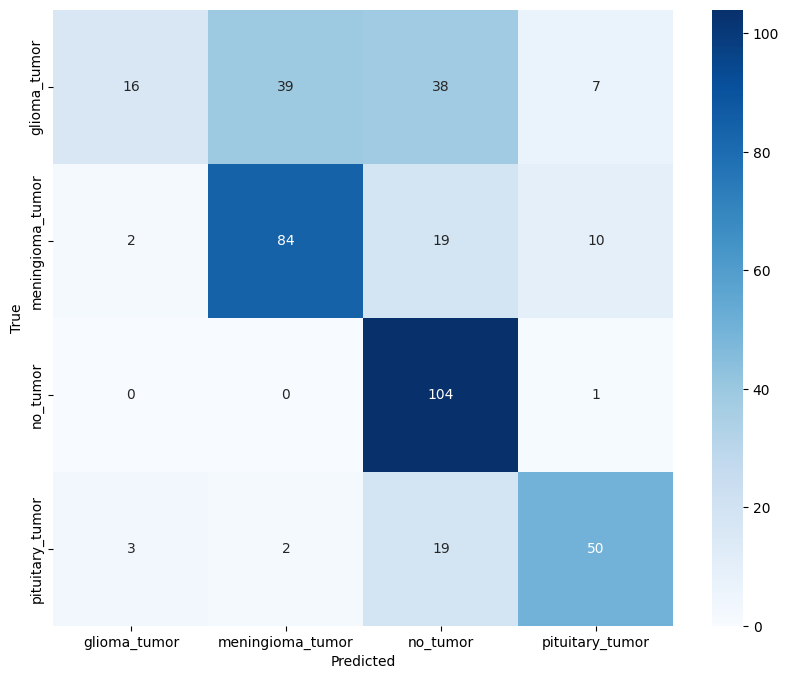

                  precision    recall  f1-score   support

    glioma_tumor       0.76      0.16      0.26       100
meningioma_tumor       0.67      0.73      0.70       115
        no_tumor       0.58      0.99      0.73       105
 pituitary_tumor       0.74      0.68      0.70        74

        accuracy                           0.64       394
       macro avg       0.69      0.64      0.60       394
    weighted avg       0.68      0.64      0.60       394



In [33]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(test_labels_encoded, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(test_labels_encoded, y_pred_classes, target_names=label_encoder.classes_))

#  Training and validation accuracy

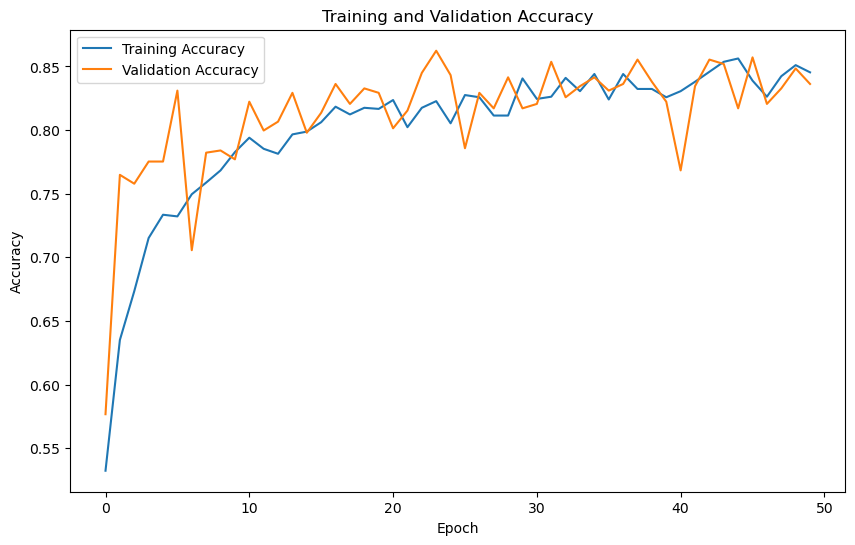

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Training and validation loss

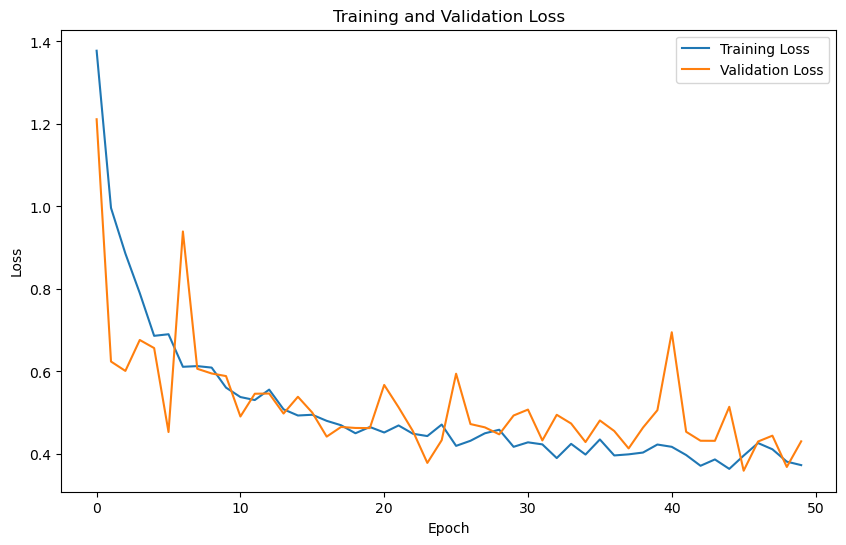

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predict a single image

In [16]:
tumor_file = r"E:\Brain Tumor Classification\Training\glioma_tumor\gg (37).jpg"
tumor_img = Image.open(tumor_file).resize(image_size)
tumor_img = np.expand_dims(np.array(tumor_img).astype('float32') / 255.0, axis=0)

prediction_prob = model.predict(tumor_img)
predicted_class = label_encoder.inverse_transform([np.argmax(prediction_prob)])
print(f"The predicted class for the tumor image is: {predicted_class[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
The predicted class for the tumor image is: glioma_tumor


# Save the model

In [34]:
model.save(r"E:\Brain Tumor Classification\model.keras")

